# Práctico: Recomendación de Artistas
---

En este práctico trabajaremos con el conjuto de datos de [LastFM](https://grouplens.org/datasets/hetrec-2011/) para el desarrollo de un sistema de recomendación que, dado el nombre de un artista musical, devuelve una lista de artistas "similares".

Para el práctico utilizaremos el conjunto de datos de LastFM que consiguieron del [notebook de instalación](./instalacion.ipynb). Se recomienda leer el [Readme](http://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-readme.txt) de los datos para saber más sobre que información contiene cada archivo.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from math import ceil

from surprise import Dataset
from surprise import Reader
from surprise import KNNWithMeans
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [2]:
artist_data = pd.read_csv("../data/lastfm/artists.dat", sep="\t")
artist_data.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [3]:
user_artist_plays = pd.read_csv("../data/lastfm/user_artists.dat", sep="\t")
user_artist_plays.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


## Actividades

El [Ejercicio 1](#Ejercicio-1---Análisis-Exploratorio-de-Datos) deberá ser realizado por quienes estén realizando cualquier parte de la materia.

El [Ejercicio 2](#Ejercicio-2---Sistema-de-Recomendación) variará de acuerdo a que parte de la materia estén realizando, quienes estén realizando la materia completa, deberán realizar ambas partes.

De acuerdo a la parte de la materia que hagan, deberán realizar una de las siguientes actividades (pueden realizar ambas si así lo desean):

La idea del práctico es hacer un análisis muy sencillo del conjunto de datos y desarrollar dos sistemas de recomendación: 
1. El primero, más sencillo, utilizando [Surpr!se](http://surpriselib.com/), y a partir de los datos de LastFM, en especial del archivo `./data/lastfm/user_artists.dat`, generar un sistema de recomendación basado en filtros colaborativos.
2. En el segundo, deberán utilizar todos los datos ofrecidos en el dataset de LastFM para generar un sistema de filtrado colaborativo más complejo, deberá utilizar las técnicas aprendidas 

basado en filtrado colaborativo (usando Surpr!se), a partir de los datos existentes.

## Ejercicio 1 - Análisis Exploratorio de Datos
---

En esta primera parte deberán hacer un análisis exploratorio de los datos, aprovechando toda la información brindada por el conjunto. A partir de eso podrán tener mayor idea de qué tipo de datos estarán enfrentando (describe o hist).

Algunas preguntas para responder:
- ¿Cuáles son los artistas que fueron más escuchados?
- ¿Cómo es la distribución de cantidad de listens por user?
- ¿Es posible ver el género más escuchado?

In [4]:
df = user_artist_plays.merge(
    artist_data[['id', 'name']], left_on='artistID', right_on='id'
).drop(columns='id')
df

,userID,artistID,weight,name
0,2,51,13883,Duran Duran
1,4,51,228,Duran Duran
2,27,51,85,Duran Duran
3,28,51,10,Duran Duran
4,62,51,528,Duran Duran
...,...,...,...,...
92829,2100,18726,337,Nyktalgia
92830,2100,18727,297,Atsakau niekadA
92831,2100,18728,281,Domantas Razauskas
92832,2100,18729,280,Atalyja


### 1.1 ¿Cuáles son los artistas que fueron más escuchados?

A continuacion se listan los 10 artistas mas escuchados

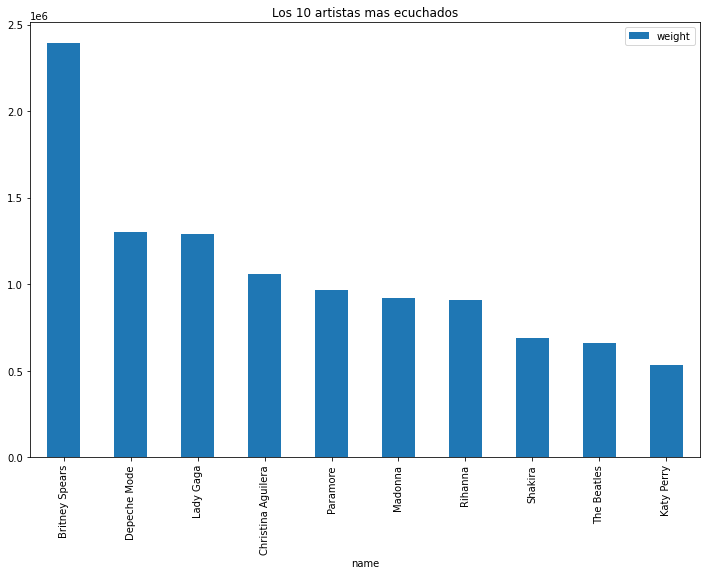

In [5]:
tmpf = df[['name', 'weight']].groupby(['name']).sum().sort_values(by='weight', ascending=False).head(10)

plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 1, 1)
tmpf.plot.bar(y='weight', ax=ax)
ax.set_title("Los 10 artistas mas ecuchados")
plt.show()

### 1.2 ¿Cómo es la distribución de cantidad de listens por user?

La mayoria de los usuarios tiene menos de 10000 listens,  

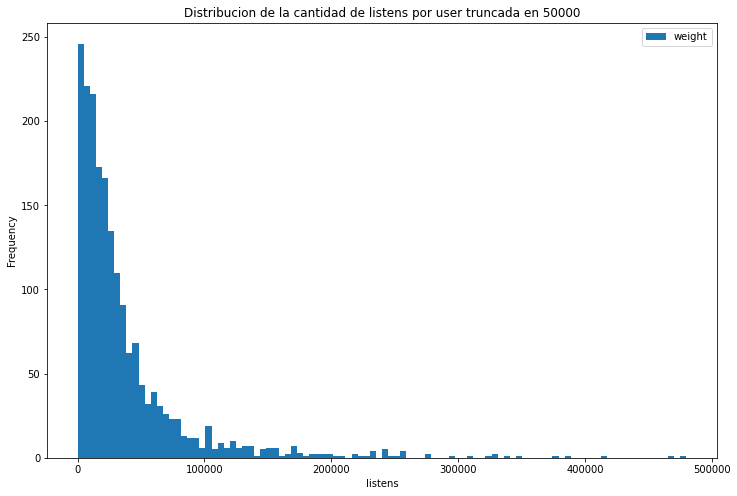

In [6]:
tmpf = df[['userID', 'weight']].groupby(['userID']).sum()
# tmpf = tmpf[tmpf.weight < 5000]

plt.figure(figsize=(12, 8))
ax = plt.subplot(1, 1, 1)
tmpf.plot.hist(bins=100, ax=ax)
ax.set_title("Distribucion de la cantidad de listens por user truncada en 50000")
ax.set_xlabel("listens")
plt.show()

### 1.3 ¿Es posible ver el género más escuchado?

No se manera explicita ya que no hay matada que tenga los generos de las canciones,
pero si se puede hacer de manera explicita viendo los artistas mas ecuchados
que para este caso el genero mas escuchado seria el **pop**.

Por otro lado tenenemos la metadata de las tag puestas por los usuarios.
A continuacion se hace un analisis usando el dataset de los tags.

In [7]:
user_taggedartists = pd.read_csv("../data/lastfm/user_taggedartists.dat", sep="\t")
user_taggedartists = user_taggedartists.drop(columns=['day', 'month', 'year'])

In [8]:
tagf = df.merge(user_taggedartists, left_on=['userID', 'artistID'], right_on=['userID', 'artistID'])
tagf

,userID,artistID,weight,name,tagID
0,4,51,228,Duran Duran,16
1,4,51,228,Duran Duran,25
2,62,51,528,Duran Duran,16
3,62,51,528,Duran Duran,17
4,62,51,528,Duran Duran,18
...,...,...,...,...,...
73353,2099,18723,87,Electrosoul System,2485
73354,2099,18724,84,Nostalgia 77,13
73355,2099,18724,84,Nostalgia 77,15
73356,2099,18724,84,Nostalgia 77,2525


In [9]:
tagf['tagID'].value_counts()

73       2499
24       2223
79       1860
18       1567
130      1562
         ... 
11232       1
9185        1
3108        1
1061        1
2049        1
Name: tagID, Length: 7927, dtype: int64

La tag que mas entradas tiene es la `73` Para ver que genero corresponde se carga
el data set tags.dat.

In [10]:
tagf = tagf.merge(
    pd.read_csv("../data/lastfm/tags.dat", sep="\t", encoding='latin-1'),
    left_on='tagID', right_on='tagID'
)
tagf

,userID,artistID,weight,name,tagID,tagValue
0,4,51,228,Duran Duran,16,new wave
1,62,51,528,Duran Duran,16,new wave
2,63,51,563,Duran Duran,16,new wave
3,117,51,1244,Duran Duran,16,new wave
4,196,51,6015,Duran Duran,16,new wave
...,...,...,...,...,...,...
73353,2085,18615,4,YEFFI,12618,site officiel : yeffi net
73354,2090,18630,1521,Doppelganger,12633,russian dark scene
73355,2090,18632,827,Bloody Dead and Sexy,12627,batcave deathrock
73356,2090,18636,414,Заражение Крови,12626,avantgrade


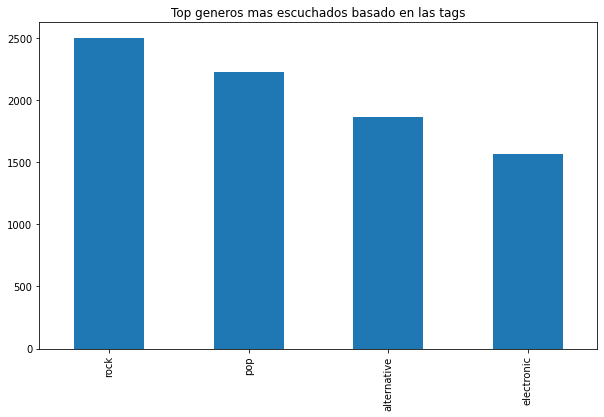

In [11]:
plt.figure(figsize=(10, 6))
tagf['tagValue'].value_counts().head(4).plot(kind = 'bar')
plt.title('Top generos mas escuchados basado en las tags')
plt.show()

De acuerdo a las etiquetas de los usuarios el genero mas escuchado es el rock segudo por el pop.

## Ejercicio 2 - Sistema de Recomendación

---

### Ejercicio 2a - Filtrados Colaborativos

Esta parte del ejercicio es obligatoria para aprobar la parte introductoria de la materia (i.e. los contenidos que se ven en las dos primeras clases), quienes estén realizando la materia completa deerán realizar también el [Ejercicio 2b](#Ejercicio-2b---Sistemas-de-Recomendación-Avanzados). 

Deberán realizar un sistema de filtrados colaborativos basado en [Surpr!se](http://surpriselib.com/), a partir de los datos que proporciona `LastFM`, en especial el archivo `user_artists.dat`. Tener en cuenta los siguientes pasos:

1. **Desarrollo de la matriz de Usuario-Contenido:** A partir del conjunto de datos deberán generar una matriz de usuario-contenido. Tener en cuenta que los ratings son implícitos, puesto que se dan a partir de la cantidad de veces que un usuario escuchó a determinado artista.
2. **Entrenamiento del algoritmo de recomendación**: Utilizando las herramientas brindadas por [Surpr!se](http://surpriselib.com/), entrenen varios modelos (al menos 3) de sistemas de recomendación basados en filtrado colaborativo a partir de su matriz de usuario-contenido. Recuerden tener en cuenta lo aprendido en la diplomatura a la hora de evaluar y validar el modelo. Si necesitan inspiración, les recomendamos revisar [este notebook con información de como entrenar un sistema de recomendación con Surpr!se](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb).
3. **Sistema de recomendación**: A partir del mejor modelo de recomendación que haya surgido del caso anterior, y utilizando los datos del archivo `artist.dat`, armar un sistema de recomendación sencillo que, dado un nombre de un artista, devuelva el top 10 de artistas más similares. La idea es que el sistema tome el nombre de un artista y devuelva el nombre de otros artistas (no simplemente tomar y devolver IDs). Se recomienda [revisar este notebook para inspiración (ver el paso número 5)](https://github.com/topspinj/pydata-workshop/blob/master/tutorial.ipynb).

### 2.1 Desarrollo de la matriz de Usuario-Contenido:

De acuerdo a los datos, y la documentacion la matriz de contenido se 
puede generara a partir, de la columanas `userID`, `artistID` y `weight`

Siendo `weigth` el rating inplicito ya que indica la cantidad de veces
que un usuario escucho a un artista.

In [12]:
df[['userID', 'artistID', 'weight']]

,userID,artistID,weight
0,2,51,13883
1,4,51,228
2,27,51,85
3,28,51,10
4,62,51,528
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


Para cargar un conjunto de datos desde un marco de datos de pandas,
usaremos el método load_from_df (), también necesitaremos un objeto Reader 
y se debe especificar el parámetro rating_scale. 

El dataframe debe tener tres columnas, correspondientes a los identificadores de usuario, 
los identificadores de elementos y las calificaciones en este orden. 
Por tanto, cada fila corresponde a una calificación determinada

In [13]:
reader = Reader(rating_scale=(df.weight.min(), df.weight.max()))
# reader = Reader(rating_scale=(1, 10))
ratings = Dataset.load_from_df(df[["userID", "artistID", "weight"]], reader)

### 2.2 Entrenamiento del algoritmo de recomendación:

In [14]:
ratings_train, ratings_test = train_test_split(ratings, test_size=0.2)

#### KNNWithMeans
 * KNNWithMeans is basic collaborative filtering algorithm, taking into account the mean ratings of each user.

In [15]:
model = KNNWithMeans(k=5).fit(ratings_train)
predictions = model.test(ratings_test)
print("RMSE on test: {:.4f}".format(rmse(predictions, verbose=False)))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE on test: 4611.4718


In [16]:
model = KNNWithMeans(verbose=False)
cross_validated_metrics = cross_validate(model, ratings, measures=['RMSE', 'MAE'], cv=3, verbose=False)
pd.DataFrame(cross_validated_metrics)

,test_rmse,test_mae,fit_time,test_time
0,4839.718846,841.749391,0.208414,1.488776
1,4079.962861,815.159053,0.210821,1.603363
2,4412.095401,855.503745,0.226288,1.637036


Matrix Factorization-based algorithms
 * SVD
     * SVD algorithm is equivalent to 
     [Probabilistic Matrix Factorization](http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf)
 * SVDpp
    * The SVDpp algorithm is an extension of SVD that takes into account
      implicit ratings.
 * NMF
    * NMF is a collaborative filtering algorithm based on Non-negative Matrix 
      Factorization. It is very similar with SVD.

In [17]:
from surprise import SVD
# from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF

In [18]:
model_svd = SVD()

cross_validated_metrics = cross_validate(
    model_svd, ratings, measures=['RMSE', 'MAE'], cv=3, verbose=False
)
pd.DataFrame(cross_validated_metrics)

,test_rmse,test_mae,fit_time,test_time
0,351953.860943,351921.698535,2.409929,0.189268
1,351976.832138,351947.860505,2.497218,0.210198
2,351953.495043,351920.821322,2.480523,0.134495


In [19]:
model_svdpp = SVDpp()

cross_validated_metrics = cross_validate(
    model_svdpp, ratings, measures=['RMSE', 'MAE'], cv=3, verbose=False
)
pd.DataFrame(cross_validated_metrics)

,test_rmse,test_mae,fit_time,test_time
0,351966.073606,351932.348942,21.017897,0.890350
1,351975.853529,351950.311931,21.267003,0.990828
2,351919.414930,351862.222224,21.319238,0.933165


In [20]:
model_nmf = NMF()

cross_validated_metrics = cross_validate(
    model_nmf, ratings, measures=['RMSE', 'MAE'], cv=3, verbose=False
)
pd.DataFrame(cross_validated_metrics)

,test_rmse,test_mae,fit_time,test_time
0,3794.268703,750.496800,3.371213,0.112124
1,2959.936216,755.611182,3.306448,0.175770
2,4542.457484,804.351816,3.348997,0.107700


El Mejor econtrado es modelo es SVDpp

### 2.3 Sistema de recomendación:model

#### Completar matriz Usuario Contenido
Usando el mejor modelo anterior

In [21]:
model_nmf.predict(28, 51).est

1

In [22]:
users = df.userID.unique()
artists = df.userID.unique()

tmp = []
for usr in users:
    for artis in artists:
        tmp.append({
            'userID': usr,
            'artistID': artis,
            'rating':ceil(model_nmf.predict(usr, artis).est)
        }
        )

#### Rating de artistas

In [23]:
user_artist = pd.DataFrame(tmp)
user_artist = user_artist.merge(
    artist_data[['id','name']], left_on=['artistID'], right_on=['id']
)
user_artist

,userID,artistID,rating,id,name
0,2,2,17,2,Diary of Dreams
1,4,2,13,2,Diary of Dreams
2,27,2,2,2,Diary of Dreams
3,28,2,1,2,Diary of Dreams
4,62,2,6,2,Diary of Dreams
...,...,...,...,...,...
3556955,1603,2085,3,2085,The Cataracs
3556956,1731,2085,3,2085,The Cataracs
3556957,1758,2085,2,2085,The Cataracs
3556958,1893,2085,2,2085,The Cataracs


#### Matriz Usuario-item

In [24]:
artist_tags = user_artist[['userID', 'name', 'rating']].pivot(
    values='rating', index=['userID'], columns=['name'])
artist_tags

name,#####,*NSYNC,1200 Micrograms,16 Horsepower,19,2009 Names in Vain,2NE1,2PM,2Pac,3 Doors Down,...,平野義久,東方神起,浜崎あゆみ,菅野よう子,雅-MIYAVI-,김종국,동방신기,백지영,소녀시대,윤하
userID,,,,,,,,,,,,,,,,,,,,,
2,13,4,20,8,2,4,12,15,14,4,...,728,728,16,21,12,728,3,20,13,11
3,3,1,2,1,1,1,3,4,2,2,...,728,728,8,3,3,728,3,2,5,1
4,5,6,2,3,2,1,2,3,6,7,...,728,728,30,1,3,728,3,3,7,2
5,3,3,2,2,1,1,5,3,2,2,...,728,728,1,2,1,728,2,2,3,1
6,1,1,1,1,1,1,1,1,1,1,...,728,728,1,1,1,728,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2095,4,2,1,1,1,1,4,3,2,4,...,728,728,11,7,1,728,1,1,3,1
2096,15,4,5,6,3,3,12,5,4,10,...,728,728,31,15,3,728,2,5,5,4
2097,3,3,1,1,1,1,1,2,3,3,...,728,728,11,1,1,728,1,1,3,1


#### Vector de contenido

#### Similitud entre tags

Similar a la matriz de correlacion.

In [25]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(artist_tags, artist_tags)
cosine_sim.shape

(1892, 1892)

In [26]:
def artist_finder(title):
    return artist_data[artist_data['name'].str.contains(title)]['name'].tolist()

In [27]:
def recomendation(title, n_recommendations, cosine_sim):
    artis_idx = dict(zip(artist_data['name'], list(artist_data.index)))
    #print(artist_finder(title))
    title = artist_finder(title)[0]

    idx = artis_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_artist = [i[0] for i in sim_scores]
    
    print("Recomendaciones para {}:".format(title))
    for artist in artist_data['name'].iloc[similar_artist]:
        print("\t{}".format(artist))

In [28]:
recomendation(title='Diary of Dreams', n_recommendations=5, cosine_sim=cosine_sim)

Recomendaciones para Diary of Dreams:
	The Rakes
	Lunatic Soul
	Maurice Ravel
	Circle II Circle
	Madonna feat. Gogol Bordello


### Ejercicio 2b - Sistemas de Recomendación Avanzados

Este ejercicio lo deberán completar quienes hayan realizado ambas partes de la materia pues requiere de los conocimientos adquiridos en las segundas dos clases. En este caso, utilizarán no sólo la información de la matriz de usuario-contenido, sino que deberán hacer uso de otra información para poder lidiar con el problema del "Cold Start", i.e. que es lo que ocurre cuando tengo nuevos usuarios o artistas. Tener en cuenta los siguientes pasos:
1. **Evaluación sobre cold start**: Para evaluar como funciona el sistema con el problema del "cold start", deberán tomar ciertos artistas y "dejarlos fuera", i.e. remover cualquier participación del artista en el sistema. Esos serán los artistas que se evaluarán como "cold start".
2. **Vectores de contenido**: Deberán generar vectores de contenido para los artistas, basados en los tags que los usuarios les dan (ver los archivos `user_taggedartists.dat` y `tags.dat`).
3. **Sistema de recomendación**: Deberán crear un sistema de recomendación que tomará como parámetros la información del artista (i.e. nombre y tags). Con dicha información, deberán disponer de un sistema de recomendación híbrido (utilizando cualquiera de las técnicas vistas en clase) que devuelva artistas similares. El sistema de recomendación deberá utilizar toda la información proporcionada para dar una mejor respuesta.
4. **Evaluación del sistema**: Deberán evaluar "a mano" el sistema sobre artistas que conozca y artistas que no conozca (i.e. que fueron dejados afuera), y hacer un análisis de lo que el sistema está devolviendo.